In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

In [2]:
# Image proportion referred to diameter, distances in pixels
D = 653.944097620
d = 216.6689743473
d1 = 290.176198804
d2 = 40.754174974
dx = 152.33333333
dy = 253.274184433
s = 6.969248238

# Proportions
D_prop = 2048
d_prop = d / D * D_prop
d1_prop = d1 / D * D_prop
d2_prop = d2 / D * D_prop
dx_prop = dx / D * D_prop
dy_prop = dy / D * D_prop
s_prop = s / D * D_prop

In [4]:
plt.figure(figsize=(15,11))
image = mpimg.imread("../Immagini/HST_measure.png")
imgplot = plt.imshow(image)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../Immagini/HST_measure.png'

<Figure size 1080x792 with 0 Axes>

In [3]:
Diam = 2.4 # metres  
lamb = 606E-9 # metres
N = 4096

Pixel_rad = 0.05  *np.pi / (180 * 3600)  # arcsecs to rad
u_cutoff = Diam / lamb
Du = 1/(N * Pixel_rad)
rp = u_cutoff / (2 * Du)

In [6]:
rp

1966.135482994712

In [4]:
def HST_pupil(CCD, *prop):
    """
    Parameters
    ----------
    CCD_x :: int, horizotal resolution
    CCD_y :: int, vertical resolution
    prop  :: tuple, proportions of images distances
             r**p, D, d, d1, d2, dx, dy, s
             
    Retrun
    ------
    pupil :: numpy.ndarray, pupil's matrix of pixels 
    """  
    x = y = np.arange(0, CCD)
    pupil = np.zeros((CCD, CCD))
    rp, D, d, d1, d2, dx, dy, s = prop
    
    s_prop = s / D * (2 * rp)
    d_prop = d / D * (2 * rp)
    d1_prop = d1 / D * (2 * rp)
    d2_prop = d2 / D * (2 * rp)
    x_prop = dx / D * (2 * rp)
    y_prop = dy / D * (2 * rp)
    
    # image center coordinates
    cx = cy = CCD//2

    # outer full circle 
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < rp**2
    pupil[mask] = 1

    # cross
    pupil[int(cx - s_prop/2): int(cy + s_prop/2 + 1), :] = 0
    pupil[:, int(cx - s_prop/2): int(cy + s_prop/2 + 1)] = 0

    # inner circle
    r = d_prop//2
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt left 
    r = d2_prop//2
    cx = CCD//2 - int(d1_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt bottom right
    cx = CCD//2 + int(x_prop)
    cy = CCD//2 + int(y_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0

    # bolt top right
    cx = CCD//2 + int(x_prop)
    cy = CCD//2 - int(y_prop)
    mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 < r**2
    pupil[mask] = 0
    
    return pupil

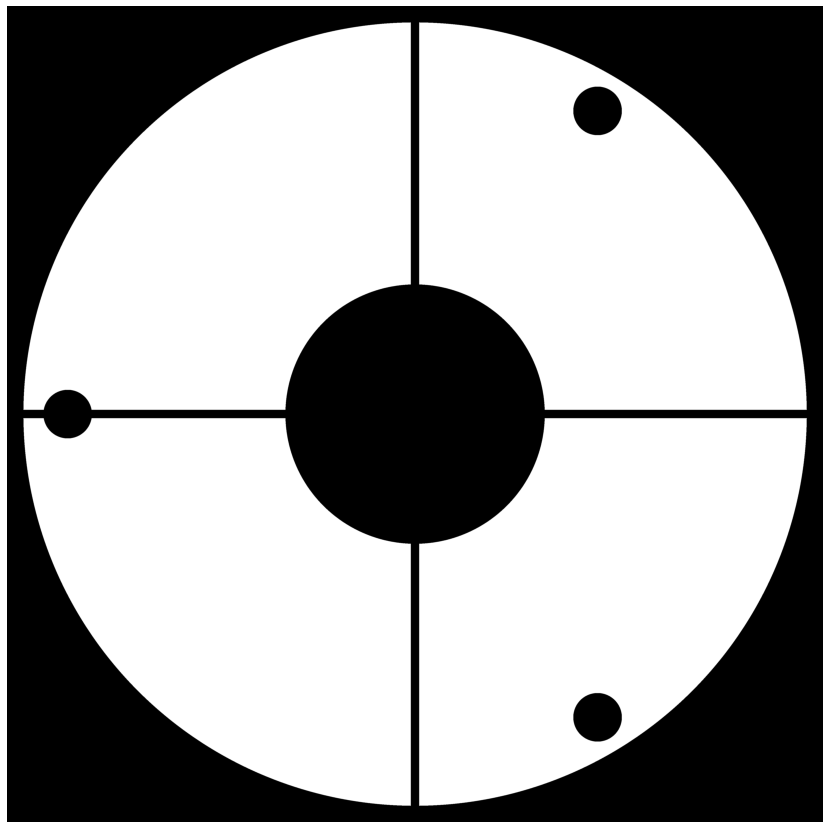

In [5]:
pupil = HST_pupil(N, rp, D, d, d1, d2, dx, dy, s)

plt.figure(figsize=(15, 15))
plt.imshow(pupil, cmap='gray')
plt.axis('off');

Compute autocorrelation

In [ ]:
# autocorrelation
res = signal.correlate(pupil, pupil, method='fft', mode='full')
# normalization
res = res/res.max()

In [7]:
# autocorrelation
res = signal.correlate(pupil, pupil, method='fft', mode='same')
# normalization
res = res/res.max()

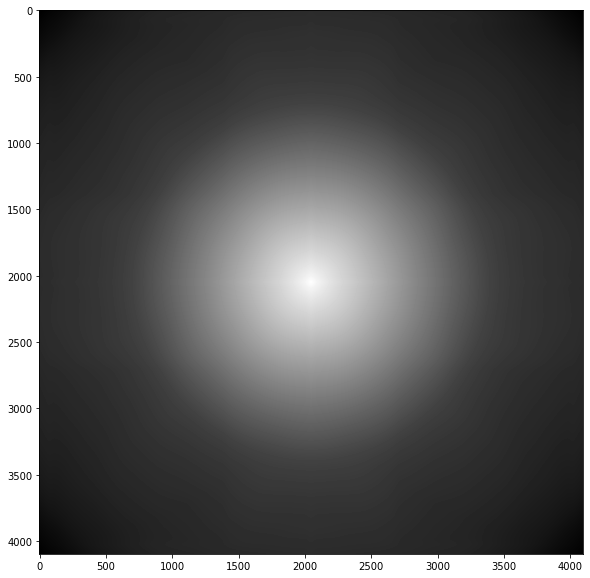

In [8]:
# print OTF
plt.figure(figsize=(10, 10))
plt.imshow(res, cmap='gray');

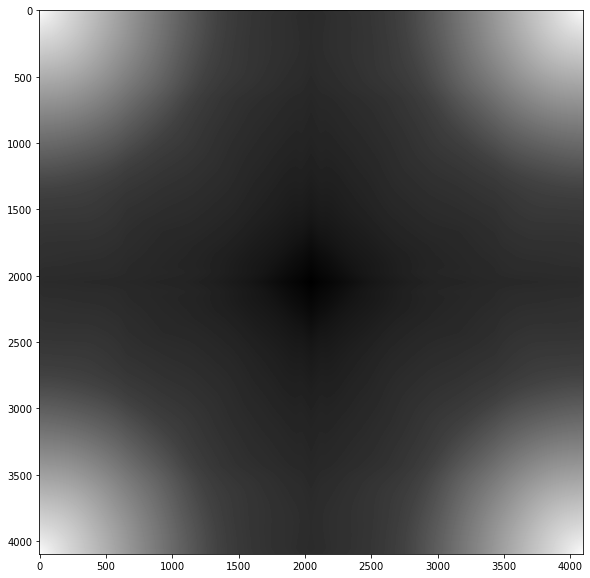

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(np.fft.fftshift(res), cmap='gray');

In [10]:
# shift max of frequecies at 0 for OTF
OTF_shift = np.fft.fftshift(res)
# Fourier antitransform of OTF
PSF = np.fft.ifft2(OTF_shift)
PSF = np.abs(PSF)
# shift back the PSF
PSF = np.fft.ifftshift(PSF)  #provare a non shiftare 

In [11]:
PSF.min(), PSF.max()

(2.9268758992731773e-16, 0.40218643415193456)

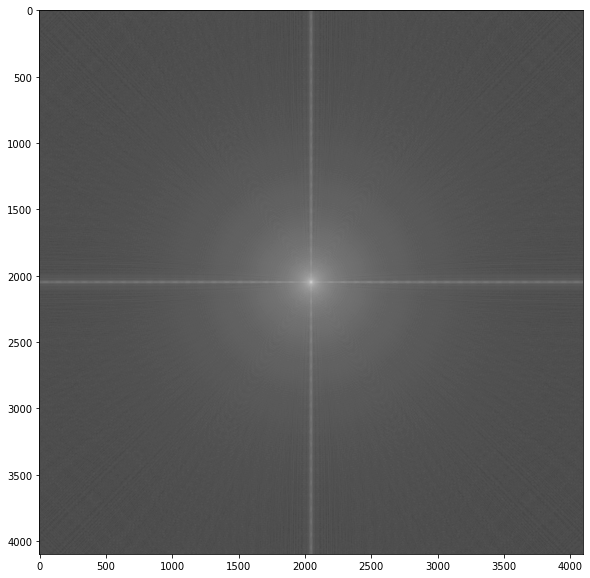

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(np.log(PSF), cmap='gray');

In [14]:
filepath = '../Results/Hubble/'
np.save(file=filepath+'Hubble_pupil.npy', arr=PSF)

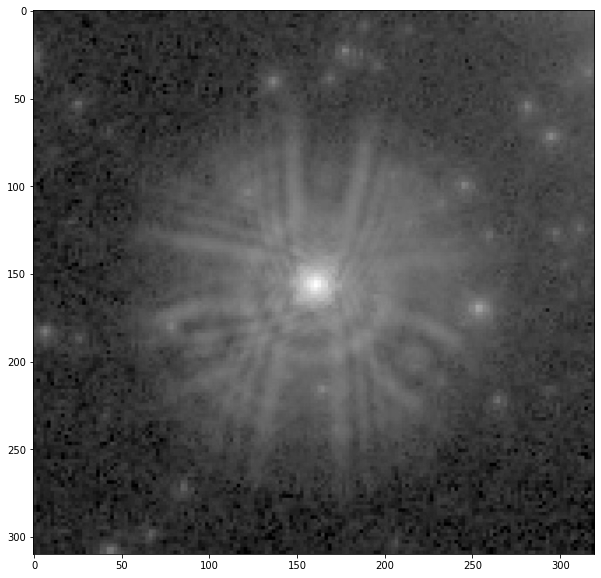

In [15]:
# PSF of Hubble telescope
plt.figure(figsize=(15, 10))
plt.imshow(mpimg.imread("../Immagini/Hubble_PSF_with_flawed_optics.jpg"), cmap='gray');

In [16]:
np.where(res == 1), np.where(np.fft.fftshift(res) == 1)

((array([2048], dtype=int64), array([2048], dtype=int64)),
 (array([0], dtype=int64), array([0], dtype=int64)))

# Fit Gaussiano

<IPython.core.display.Javascript object>


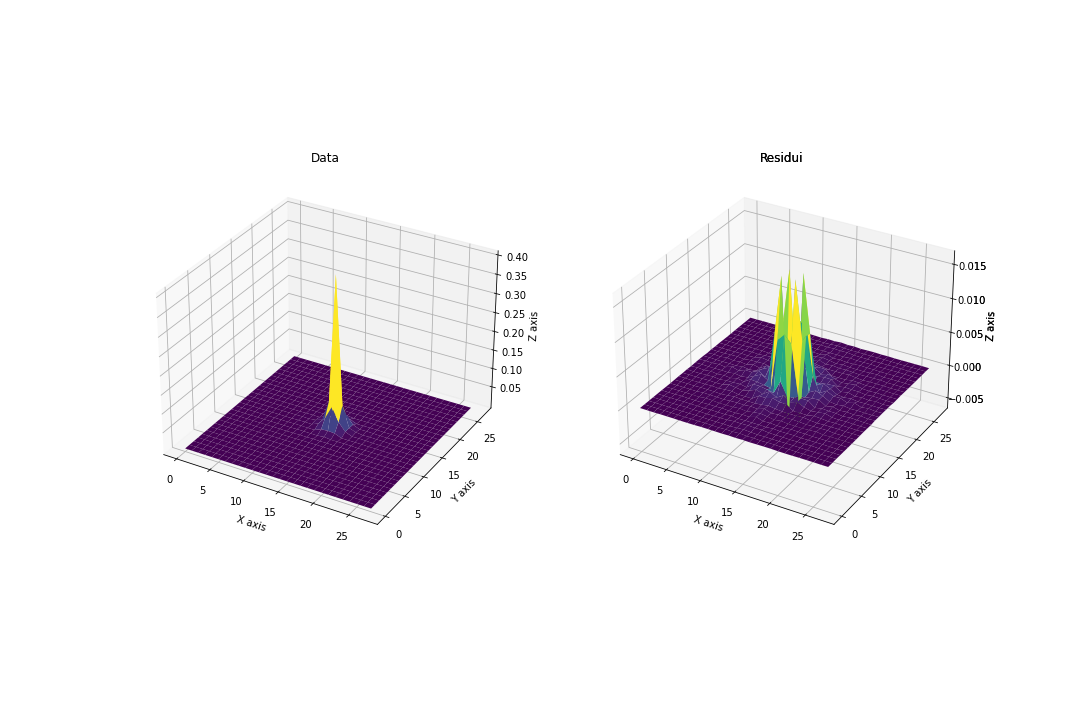

In [18]:
%matplotlib notebook

from astropy.modeling import models, fitting
from mpl_toolkits.mplot3d import Axes3D

def Fit(PSF=PSF, bb=14):
        
    max_int = np.max(PSF)
    yc = np.where(PSF == max_int)[0][0] 
    xc = np.where(PSF == max_int)[1][0]
    
    box = PSF[int(yc)-bb:int(yc)+bb, int(xc)-bb:int(xc)+bb]
       
    yp, xp = box.shape 
    y, x = np.mgrid[:yp, :xp]
    
     
    fit_f = fitting.LevMarLSQFitter()   
    f_init = models.Gaussian2D(amplitude=max_int, x_mean=bb, y_mean=bb)
    f = fit_f(f_init, x, y, box)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, y, box, cmap='viridis', linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Data')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x, y, box - f(x,y), cmap='viridis', linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Residui')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x, y, box - f(x,y), cmap='viridis', linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Residui')
        
    return box, f, f(x,y)

box, f, fit = Fit()

In [19]:
f.x_stddev[0], f.y_stddev[0], f.x_fwhm, f.y_fwhm, f.theta[0]

(0.5371582159649281,
 0.5368853332459366,
 1.2649109343072764,
 1.2642683446106526,
 -0.0020643343842529738)

<IPython.core.display.Javascript object>


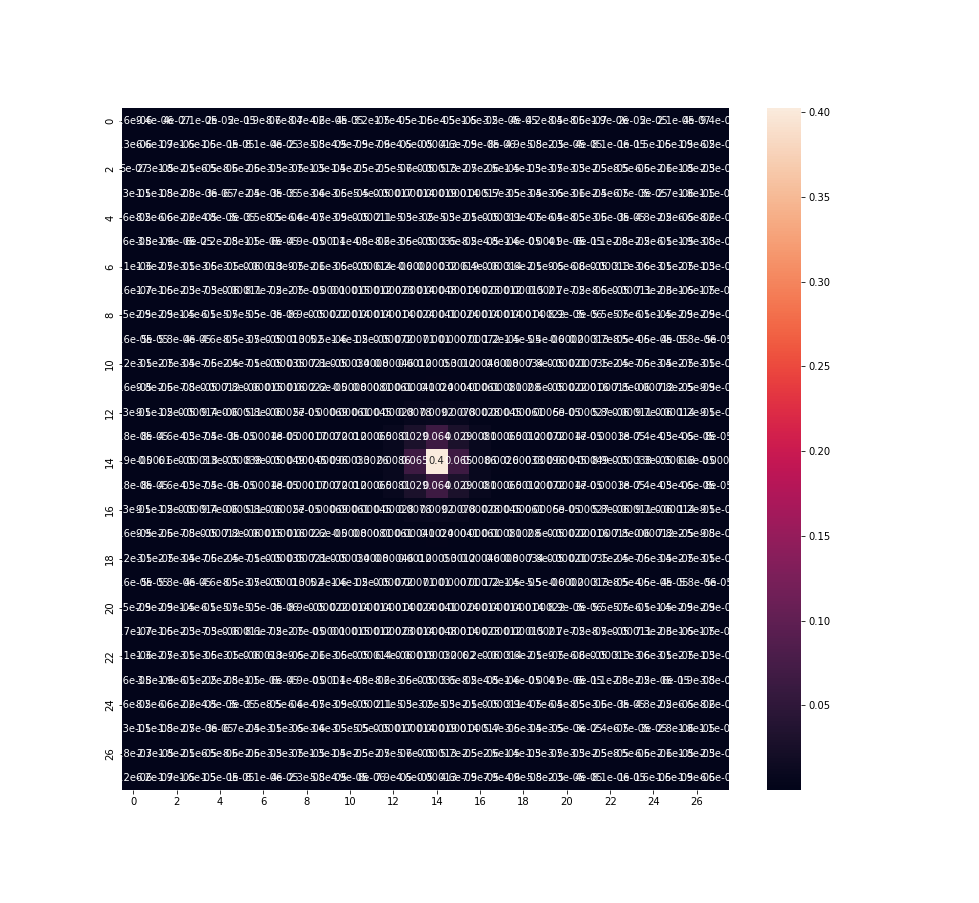

<AxesSubplot:>

In [21]:
import seaborn as sns

sns.heatmap(box, annot=True)

In [22]:
print(f.x_fwhm, f.y_fwhm)

pupilla = np.pi * f.x_fwhm * f.y_fwhm
stella = np.pi * 4.438430645281045 * 3.7656701097635352

(1/pupilla - 1/stella) / (1/pupilla)

1.2649109343072764 1.2642683446106526


0.9043186043196378

In [23]:
pupilla = np.pi * f.x_fwhm * f.y_fwhm
stella = np.pi * 2.9083348713619586 * 3.1258168650066995

(1/pupilla - 1/stella) / (1/pupilla)



0.824089699639341

# References 
1. Hubble instrument [dimensions](https://www.teledyne-e2v.com/news/e2v-ccd-imaging-sensors-to-enable-nasas-hubble-space-telescope-to-explore-the-nature-and-history-of-our-universe-with-greater-capability-than-ever-before/)
2. Hubble instrument [caracteristics](https://hst-docs.stsci.edu/acsihb/chapter-3-acs-capabilities-design-and-operations/3-5-acs-quick-reference-guide)
3. Hubble [pupil](https://www.semanticscholar.org/paper/Hubble-Space-Telescope-prescription-retrieval.-Redding-Dumont/bd291aa8300cec9fb42e7ce549111b9dd4cc9e1a/figure/4) image
4. Hubble [PSF](https://en.wikipedia.org/wiki/Hubble_Space_Telescope#/media/File:Hubble_PSF_with_flawed_optics.jpg)

In [24]:
pupil = np.zeros((60,60))
x = y = np.arange(0, 60)
cx = cy = 30

# outer full circle 
mask = (x[np.newaxis, :] - cx)**2 + (y[:, np.newaxis] - cy)**2 <= 10**2
pupil[mask] = 1

<IPython.core.display.Javascript object>


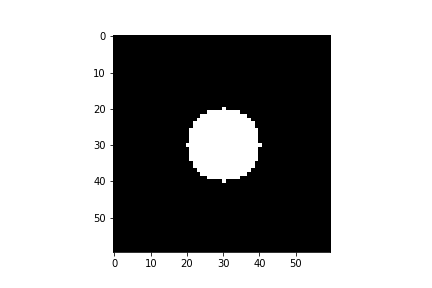

In [25]:
plt.imshow(pupil, cmap='gray');